### Packages

In [3]:
import numpy as np
from scipy import linalg as ls 
import networkx as nx 
from functools import reduce
from tqdm import tqdm
import source_file as sf
import matplotlib.pyplot as plt
import matplotlib as mpl 


mpl.rcParams['font.family'] = 'serif' #'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1


### Numerics

In [2]:
#Complete graph Hamiltonian
def H_CG(N,gamma,kappa):
    #Hamiltonian matrix
    ket_s = (1.0/np.sqrt(N))*np.ones((N,1))
    H = -gamma*N*np.dot(ket_s,np.conjugate(ket_s).transpose())
        
    # Ensure H can handle complex numbers
    H = H.astype(complex)
    w = 10 #the theory is invariant of this choice
    H[w,w] = H[w,w] - 1 - 1j*kappa
    
    return H   


### Theory

In [98]:
#theoretical eigenvalues in the two dimensional basis
def lambda_pm(N,gamma,kappa):

    lambda_plus  = -(gamma*N + 1 + 1.0j*kappa)/2  + np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))
    lambda_minus = -(gamma*N + 1 + 1.0j*kappa)/2  - np.sqrt(((gamma*N + 1 + 1.0j*kappa)/2)**2 - (gamma*N - gamma)*(1 + 1.0j*kappa))

    return lambda_plus,lambda_minus



def imag_lambda_pm(N,gamma,kappa):
   # a  = ((gamma*N + 1)**2 - kappa**2)/4 - (gamma*N - gamma)
    a = 1/4 + gamma - N*gamma/2 + N*N*gamma*gamma/4 - kappa*kappa/4
    b  = kappa/2 + gamma*kappa - N*gamma*kappa/2
    mod_z = (1/4)*np.sqrt(4*(kappa*kappa)*(-1 + (N-2)*gamma)**2 + (-1 +2*(N - 2)*gamma - N*N*gamma*gamma + kappa*kappa)**2)
    #mod_z = np.sqrt(a**2 + b**2)

    imag_lambda_plus = - kappa/2 + np.sign(b)*np.sqrt((mod_z - a)/2)
    imag_lambda_minus = - kappa/2 - np.sign(b)*np.sqrt((mod_z - a)/2)

    return imag_lambda_plus, imag_lambda_minus


#theoretical right eigenvectors in the two dimensional basis
def lambdaR(N,gamma,kappa):

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- lambda_plus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaR_plus = np.array([a_plus,b_plus])

    a_minus = (- lambda_minus - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaR_minus = np.array([a_minus,b_minus])

    return lambdaR_plus, lambdaR_minus


#theoretical left eigenvectors in the two dimensional basis
def lambdaL(N,gamma,kappa):

    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    a_plus = (- np.conj(lambda_plus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_plus = 1
   
    lambdaL_plus = np.array([a_plus,b_plus])

    a_minus = (- np.conj(lambda_minus) - gamma*(N -1))/(gamma*np.sqrt(N-1))
    b_minus = 1
    lambdaL_minus = np.array([a_minus,b_minus])

    return lambdaL_plus, lambdaL_minus

def overlap(N,gamma,kappa):

    lambdaR_plus, lambdaR_minus = lambdaR(N,gamma,kappa)
    lambdaL_plus, lambdaL_minus = lambdaL(N,gamma,kappa)

    #initial state
    ket_s = np.array([1.0/np.sqrt(N) ,np.sqrt((N-1)/N)])

    overlap_plus =(1/np.abs(np.vdot(lambdaL_plus,lambdaR_plus))**2)*np.vdot(lambdaR_plus,lambdaR_plus)*np.abs(np.vdot(ket_s, lambdaL_plus))**2

    overlap_minus =(1/np.abs(np.vdot(lambdaL_minus,lambdaR_minus))**2)*np.vdot(lambdaR_minus,lambdaR_minus)*np.abs(np.vdot(ket_s, lambdaL_minus))**2

    overlap_pm = (1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus)
    overlap_mp = (1/(np.vdot(lambdaR_minus,lambdaL_minus)*np.vdot(lambdaL_plus,lambdaR_plus)))*np.vdot(ket_s,lambdaL_minus)*np.vdot(lambdaL_plus,ket_s)*np.vdot(lambdaR_minus, lambdaR_plus)
    #overlap_pm = np.real((1/(np.vdot(lambdaR_plus,lambdaL_plus)*np.vdot(lambdaL_minus,lambdaR_minus)))*np.vdot(ket_s,lambdaL_plus)*np.vdot(lambdaL_minus,ket_s)*np.vdot(lambdaR_plus, lambdaR_minus))

    return overlap_plus, overlap_minus,overlap_pm,overlap_mp


def surv_prob_theory(N,gamma,kappa,t):

    #eigenvalues
    lambda_plus,lambda_minus = lambda_pm(N,gamma,kappa)

    #overlapsgamma
    overlap_plus, overlap_minus,overlap_pm,overlap_mp = overlap(N,gamma,kappa)


    first_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_plus))*t)*overlap_plus
    second_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_minus))*t)*overlap_minus
    third_term  = np.exp(-1.0j*(lambda_plus - np.conj(lambda_minus))*t)*overlap_pm
    fourth_term = np.exp(-1.0j*(lambda_minus - np.conj(lambda_plus))*t)*overlap_mp


    s = first_term + second_term + third_term + fourth_term 
    return s

### Overlaps

In [43]:
N = 500
w  = 10
kappa = [0.01,0.1,1]
gamma = np.linspace(0.1/N,2/N,100)


overlap_plus = np.zeros((len(gamma),len(kappa)))
overlap_minus = np.zeros((len(gamma),len(kappa)))
overlap_pm = np.zeros((len(gamma),len(kappa)))

for j in range(len(kappa)):
    for i in tqdm(range(len(gamma))):
        overlap_plus[i,j], overlap_minus[i,j],overlap_pm[i,j] = overlap(N,gamma[i],kappa[j])

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_6784/254043996.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_plus[i,j], overlap_minus[i,j],overlap_pm[i,j] = overlap(N,gamma[i],kappa[j])
100%|██████████| 100/100 [00:00<00:00, 36960.73it/s]


In [88]:
N = 500
overlap(N,1/N,0.1)

(np.complex128(3.3845629687755685+0j),
 np.complex128(1.2935821402085705+0j),
 np.float64(-1.8390725544920286))

In [44]:
 for j in range(len(kappa)):
    # Compute the total overlaps
    total_overlap = overlap_plus[:,j] + overlap_minus[:,j] + 2 * overlap_pm[:,j]

    # If overlaps are complex and you're only interested in real part:
    # total_overlap = np.real(overlap_plus + overlap_minus + 2 * overlap_pm)

    # Check closeness to 1
    is_close = np.isclose(total_overlap, 1.0, atol=1e-10)

    # Check if all are close to 1
    if np.all(is_close):
        print("All overlap sums are close to 1.")
    else:
        print("Overlap sums not close to 1 at indices:")
        for i, ok in enumerate(is_close):
            if not ok:
                print(f"i = {i}, total = {total_overlap[i]}")

All overlap sums are close to 1.
All overlap sums are close to 1.
All overlap sums are close to 1.


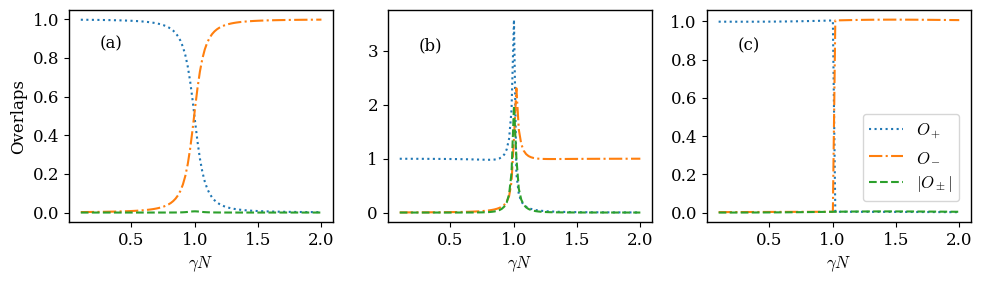

In [54]:
# Visualization - overlap for different kappa
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
ax1 = axes[0]
ax1.plot(gamma*N, overlap_plus[:,0] ,':',label = r'$O_+$')
ax1.plot(gamma*N, overlap_minus[:,0],'-.',label = r'$O_-$')
ax1.plot(gamma*N, np.abs(overlap_pm[:,0]),'--',label = r'$\vert O_\pm \vert$')


ax1.set_ylabel(r"Overlaps")
ax1.set_xlabel(r"$\gamma N$")
ax1.text(0.25, 0.85, r'(a)', fontsize = 12)


ax2 = axes[1]
ax2.plot(gamma*N, overlap_plus[:,1] ,':',label = r'$O_+$')
ax2.plot(gamma*N, overlap_minus[:,1],'-.',label = r'$O_-$')
ax2.plot(gamma*N,  np.abs(overlap_pm[:,1]),'--',label = r'$\vert O_\pm \vert$')



ax2.set_xlabel(r"$\gamma N$")
ax2.text(0.25, 3, r'(b)', fontsize = 12)



ax3 = axes[2]
ax3.plot(gamma*N,  overlap_plus[:,2] ,':',label = r'$O_+$')
ax3.plot(gamma*N,  overlap_minus[:,2],'-.',label = r'$O_-$')
ax3.plot(gamma*N,  np.abs(overlap_pm[:,2]),'--',label = r'$\vert O_\pm \vert$')

ax3.set_xlabel(r"$\gamma N$")


ax3.text(0.25, 0.85, r'(c)', fontsize = 12)


plt.legend(fontsize = 12, loc = (0.59,0.1))
plt.tight_layout()

plt.savefig(r'../Figures/Biorthogonal/overlap_N500_all.pdf',dpi = 800, bbox_inches = 'tight', transparent = True )
plt.show()

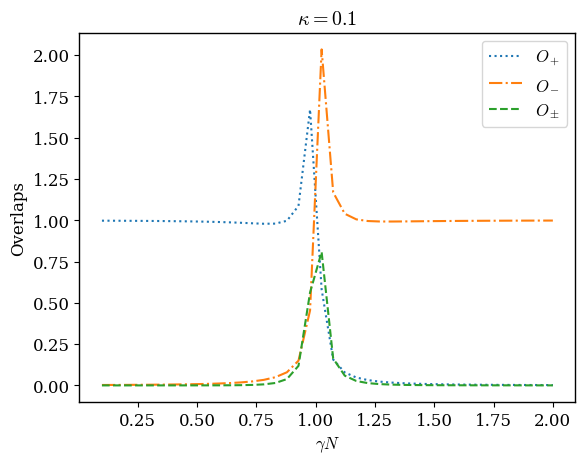

In [42]:
plt.plot(gamma*N, overlap_plus,':',label = r'$O_+$')
plt.plot(gamma*N, overlap_minus,'-.',label = r'$O_-$')
plt.plot(gamma*N, np.abs(overlap_pm),'--',label = r'$O_\pm$')
plt.legend()
plt.title(rf'$\kappa = {kappa}$')
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Overlaps')

#plt.savefig(rf'../Figures/Biorthogonal/overlap_N5000_kappa{kappa}.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

### Imaginary part of the eigenvalues scaling with N

In [76]:
N = np.arange(100,10000,100)
kappa = 0.0001

imag_lambda_plus = np.zeros(len(N))
imag_lambda_minus = np.zeros(len(N))

for i in range(len(N)):

    imag_lambda_plus[i],imag_lambda_minus[i] = imag_lambda_pm(N[i],1/N[i],kappa)

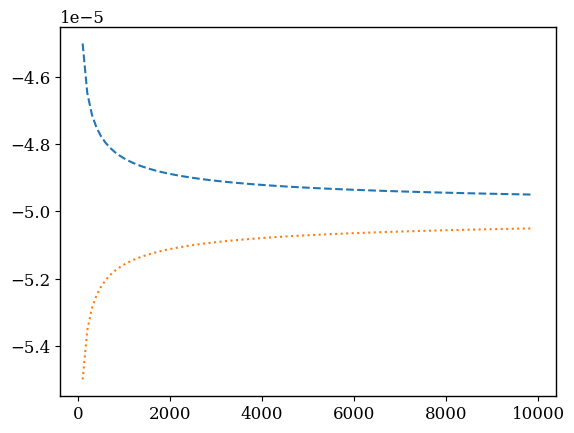

In [77]:
plt.plot(N, imag_lambda_plus,'--')
plt.plot(N,imag_lambda_minus,':')




plt.show()

### Survival probability plots

In [99]:
N = 500
T = 400
dt = 0.01
m  = int(T/dt)

t = np.arange(0,T,dt)
s_prob = np.zeros(m)

for j in range(m):
    s_prob[j] = surv_prob_theory(N,1/N,0.1,t[j])

/tmp/ipykernel_6784/2842004073.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  s_prob[j] = surv_prob_theory(N,1/N,0.1,t[j])


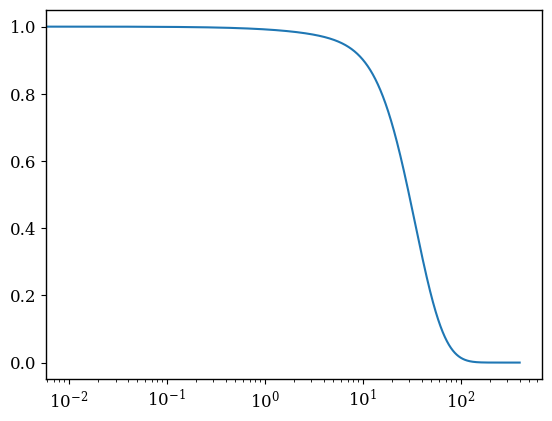

In [102]:
plt.plot(t,s_prob)
plt.xscale('log')

### Comparisions

In [97]:
#parameters
N = np.arange(100,5100,100)
kappa = [0.1,0.25,0.5,0.75,1.0]
#gamma = 1/10





lambda_plus_theory = np.zeros((len(kappa), len(N)), dtype = complex)
lambda_minus_theory = np.zeros((len(kappa), len(N)), dtype = complex)

imag_lambda_plus = np.zeros((len(kappa), len(N)))
imag_lambda_minus = np.zeros((len(kappa), len(N)))


for j in tqdm(range(len(kappa))):
    for i in tqdm(range(len(N))):
        
        #theory
        lambda_plus_theory[j,i],lambda_minus_theory[j,i] =  lambda_pm(N[i],1/N[i],kappa[j])
        imag_lambda_plus[j,i], imag_lambda_minus[j,i] = imag_lambda_pm(N[i],1/N[i],kappa[j])

100%|██████████| 5/5 [00:00<00:00, 647.73it/s]


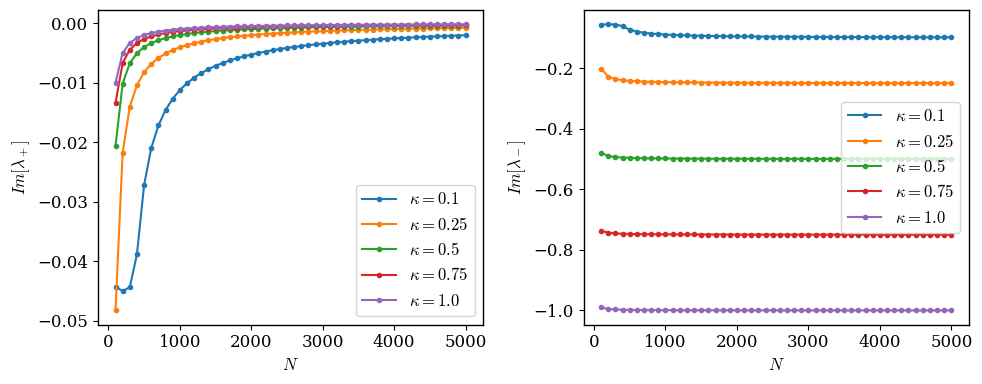

In [98]:
# Visualization 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax1 = axes[0]

#ax1.plot(gamma*N, np.imag(lambda_plus_theory[0,:]),'.-', label = rf'$\kappa = {kappa[0]}$')
ax1.plot(N, imag_lambda_plus[0,:],'.-', label = rf'$\kappa = {kappa[0]}$')
ax1.plot(N, imag_lambda_plus[1,:],'.-', label = rf'$\kappa = {kappa[1]}$')
ax1.plot(N, imag_lambda_plus[2,:],'.-', label = rf'$\kappa = {kappa[2]}$')
ax1.plot(N, imag_lambda_plus[3,:],'.-', label = rf'$\kappa = {kappa[3]}$')
ax1.plot(N, imag_lambda_plus[4,:],'.-', label = rf'$\kappa = {kappa[4]}$')

ax1.set_ylabel(r"$Im[\lambda_+]$")
ax1.set_xlabel(r"$N$")
ax1.legend()

ax2 = axes[1]

ax2.plot(N, imag_lambda_minus[0,:],'.-', label = rf'$\kappa = {kappa[0]}$')
ax2.plot(N, imag_lambda_minus[1,:],'.-', label = rf'$\kappa = {kappa[1]}$')
ax2.plot(N, imag_lambda_minus[2,:],'.-', label = rf'$\kappa = {kappa[2]}$')
ax2.plot(N, imag_lambda_minus[3,:],'.-', label = rf'$\kappa = {kappa[3]}$')
ax2.plot(N, imag_lambda_minus[4,:],'.-', label = rf'$\kappa = {kappa[4]}$')

ax2.set_ylabel(r"$Im[\lambda_-]$")
ax2.set_xlabel(r"$N$")

ax2.legend()

plt.tight_layout()

#plt.savefig(rf'../Figures/Biorthogonal/imag_lambda_pm_N500.pdf',bbox_inches = 'tight', transparent = True)
plt.show()

In [84]:
#parameters
N = np.arange(100,5100,100)
kappa = [0.1,0.25,0.5,0.75,1.0]
#gamma = np.linspace(0.1/N,2/N,40)
gamma = 1/5000


#eigval_comp_0 = np.zeros((len(kappa), len(gamma)), dtype = complex)
#eigval_comp_1 = np.zeros((len(kappa), len(gamma)), dtype = complex)


lambda_plus_theory = np.zeros((len(kappa), len(gamma)), dtype = complex)
lambda_minus_theory = np.zeros((len(kappa), len(gamma)), dtype = complex)

imag_lambda_plus = np.zeros((len(kappa), len(gamma)))
imag_lambda_minus = np.zeros((len(kappa), len(gamma)))


for j in tqdm(range(len(kappa))):
    for i in tqdm(range(len(gamma))):
        
        #theory
        lambda_plus_theory[j,i],lambda_minus_theory[j,i] =  lambda_pm(N,gamma[i],kappa[j])
        imag_lambda_plus[j,i], imag_lambda_minus[j,i] = imag_lambda_pm(N,gamma[i],kappa[j])

        #Hamiltonian matrix
        #H = H_CG(N,gamma[i],kappa[j])

        #get the eigenvalue 
        #eigval,_ = np.linalg.eig(H)
        #sorted_indices = np.argsort(np.real(eigval))  # Get indices for sorting eigenvalues
        #eigval_sorted = eigval[sorted_indices] 


        #eigval_comp_0[j,i] = eigval_sorted[0]
        #eigval_comp_1[j,i] = eigval_sorted[1]

100%|██████████| 5/5 [00:00<00:00, 347.01it/s]


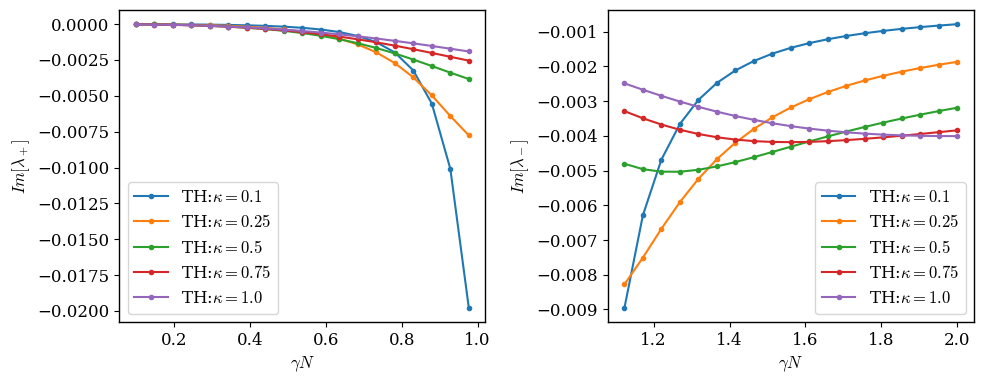

In [85]:
# Visualization 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax1 = axes[0]



#ax1.plot(gamma*N, np.imag(lambda_plus_theory[0,:]),'.-', label = rf'$\kappa = {kappa[0]}$')
ax1.plot(gamma[:19]*N, imag_lambda_plus[0,:][:19],'.-', label = rf'TH:$\kappa = {kappa[0]}$')
ax1.plot(gamma[:19]*N, imag_lambda_plus[1,:][:19],'.-', label = rf'TH:$\kappa = {kappa[1]}$')
ax1.plot(gamma[:19]*N, imag_lambda_plus[2,:][:19],'.-', label = rf'TH:$\kappa = {kappa[2]}$')
ax1.plot(gamma[:19]*N, imag_lambda_plus[3,:][:19],'.-', label = rf'TH:$\kappa = {kappa[3]}$')
ax1.plot(gamma[:19]*N, imag_lambda_plus[4,:][:19],'.-', label = rf'TH:$\kappa = {kappa[4]}$')

#ax1.plot(gamma*N, np.imag(lambda_plus_theory[1,:]),'.-', label = rf'$\kappa = {kappa[1]}$')
#ax1.plot(gamma*N, np.imag(lambda_plus_theory[2,:]),'.-', label = rf'$\kappa = {kappa[2]}$')
#ax1.plot(gamma*N, np.imag(lambda_plus_theory[3,:]),'.-', label = rf'$\kappa = {kappa[3]}$')
#ax1.plot(gamma*N, np.imag(lambda_plus_theory[4,:]),'.-', label = rf'$\kappa = {kappa[4]}$')



ax1.set_ylabel(r"$Im[\lambda_+]$")
ax1.set_xlabel(r"$\gamma N$")
ax1.legend()

ax2 = axes[1]


ax2.plot(gamma[21:]*N, imag_lambda_minus[0,:][21:],'.-', label = rf'TH:$\kappa = {kappa[0]}$')
ax2.plot(gamma[21:]*N, imag_lambda_minus[1,:][21:],'.-', label = rf'TH:$\kappa = {kappa[1]}$')
ax2.plot(gamma[21:]*N, imag_lambda_minus[2,:][21:],'.-', label = rf'TH:$\kappa = {kappa[2]}$')
ax2.plot(gamma[21:]*N, imag_lambda_minus[3,:][21:],'.-', label = rf'TH:$\kappa = {kappa[3]}$')
ax2.plot(gamma[21:]*N, imag_lambda_minus[4,:][21:],'.-', label = rf'TH:$\kappa = {kappa[4]}$')

#ax2.plot(gamma*N, np.imag(lambda_minus_theory[1,:]),'.-', label = rf'$\kappa = {kappa[1]}$')
#ax2.plot(gamma*N, np.imag(lambda_minus_theory[2,:]),'.-', label = rf'$\kappa = {kappa[2]}$')
#ax2.plot(gamma*N, np.imag(lambda_minus_theory[3,:]),'.-', label = rf'$\kappa = {kappa[3]}$')
#ax2.plot(gamma*N, np.imag(lambda_minus_theory[4,:]),'.-', label = rf'$\kappa = {kappa[4]}$')


ax2.set_ylabel(r"$Im[\lambda_-]$")
ax2.set_xlabel(r"$\gamma N$")

ax2.legend()



plt.tight_layout()

#plt.savefig(rf'../Figures/Biorthogonal/imag_lambda_pm_N500.pdf',bbox_inches = 'tight', transparent = True)
plt.show()

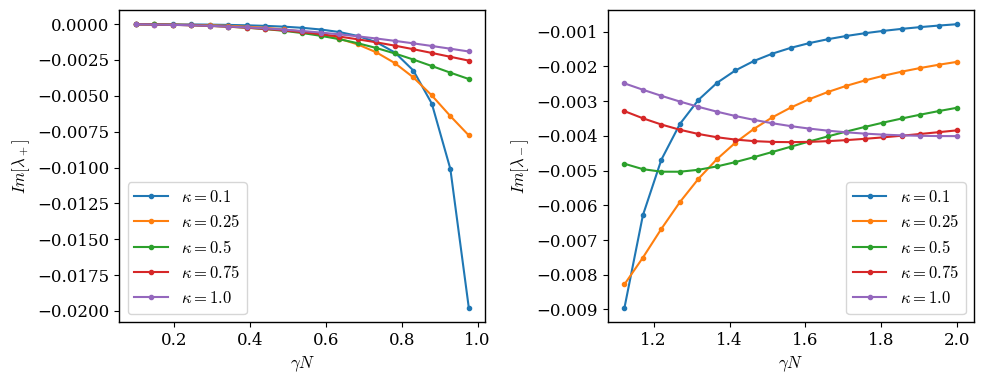

In [60]:
# Visualization 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax1 = axes[0]



ax1.plot(gamma[:19]*N, np.imag(lambda_plus_theory[0,:][:19]),'.-', label = rf'$\kappa = {kappa[0]}$')
ax1.plot(gamma[:19]*N, np.imag(lambda_plus_theory[1,:][:19]),'.-', label = rf'$\kappa = {kappa[1]}$')
ax1.plot(gamma[:19]*N, np.imag(lambda_plus_theory[2,:][:19]),'.-', label = rf'$\kappa = {kappa[2]}$')
ax1.plot(gamma[:19]*N, np.imag(lambda_plus_theory[3,:][:19]),'.-', label = rf'$\kappa = {kappa[3]}$')
ax1.plot(gamma[:19]*N, np.imag(lambda_plus_theory[4,:][:19]),'.-', label = rf'$\kappa = {kappa[4]}$')



ax1.set_ylabel(r"$Im[\lambda_+]$")
ax1.set_xlabel(r"$\gamma N$")
ax1.legend()

ax2 = axes[1]

ax2.plot(gamma[21:]*N, np.imag(lambda_minus_theory[0,:][21:]),'.-', label = rf'$\kappa = {kappa[0]}$')
ax2.plot(gamma[21:]*N, np.imag(lambda_minus_theory[1,:][21:]),'.-', label = rf'$\kappa = {kappa[1]}$')
ax2.plot(gamma[21:]*N, np.imag(lambda_minus_theory[2,:][21:]),'.-', label = rf'$\kappa = {kappa[2]}$')
ax2.plot(gamma[21:]*N, np.imag(lambda_minus_theory[3,:][21:]),'.-', label = rf'$\kappa = {kappa[3]}$')
ax2.plot(gamma[21:]*N, np.imag(lambda_minus_theory[4,:][21:]),'.-', label = rf'$\kappa = {kappa[4]}$')


ax2.set_ylabel(r"$Im[\lambda_-]$")
ax2.set_xlabel(r"$\gamma N$")

ax2.legend()



plt.tight_layout()

#plt.savefig(rf'../Figures/Biorthogonal/imag_lambda_pm_N500_zoomed.pdf',bbox_inches = 'tight', transparent = True)
plt.show()

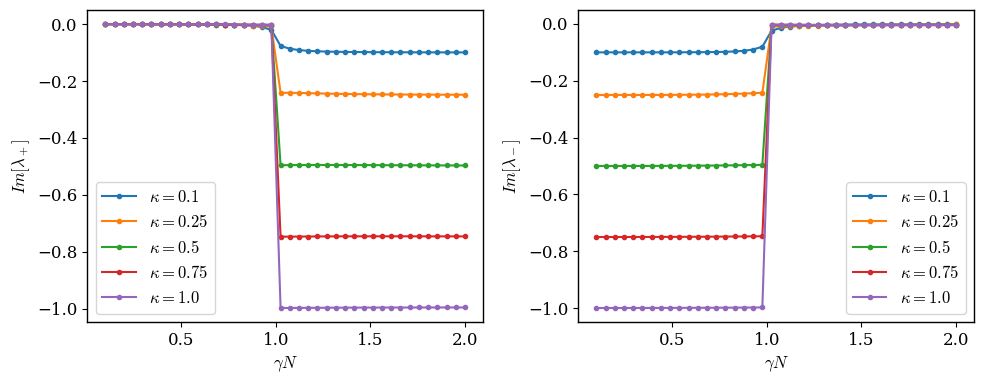

In [61]:
# Visualization 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax1 = axes[0]



ax1.plot(gamma*N, np.imag(lambda_plus_theory[0,:]),'.-', label = rf'$\kappa = {kappa[0]}$')
ax1.plot(gamma*N, np.imag(lambda_plus_theory[1,:]),'.-', label = rf'$\kappa = {kappa[1]}$')
ax1.plot(gamma*N, np.imag(lambda_plus_theory[2,:]),'.-', label = rf'$\kappa = {kappa[2]}$')
ax1.plot(gamma*N, np.imag(lambda_plus_theory[3,:]),'.-', label = rf'$\kappa = {kappa[3]}$')
ax1.plot(gamma*N, np.imag(lambda_plus_theory[4,:]),'.-', label = rf'$\kappa = {kappa[4]}$')



ax1.set_ylabel(r"$Im[\lambda_+]$")
ax1.set_xlabel(r"$\gamma N$")
ax1.legend()

ax2 = axes[1]

ax2.plot(gamma*N, np.imag(lambda_minus_theory[0,:]),'.-', label = rf'$\kappa = {kappa[0]}$')
ax2.plot(gamma*N, np.imag(lambda_minus_theory[1,:]),'.-', label = rf'$\kappa = {kappa[1]}$')
ax2.plot(gamma*N, np.imag(lambda_minus_theory[2,:]),'.-', label = rf'$\kappa = {kappa[2]}$')
ax2.plot(gamma*N, np.imag(lambda_minus_theory[3,:]),'.-', label = rf'$\kappa = {kappa[3]}$')
ax2.plot(gamma*N, np.imag(lambda_minus_theory[4,:]),'.-', label = rf'$\kappa = {kappa[4]}$')


ax2.set_ylabel(r"$Im[\lambda_-]$")
ax2.set_xlabel(r"$\gamma N$")

ax2.legend()



plt.tight_layout()

plt.savefig(rf'../Figures/Biorthogonal/imag_lambda_pm_N500.pdf',bbox_inches = 'tight', transparent = True)
plt.show()

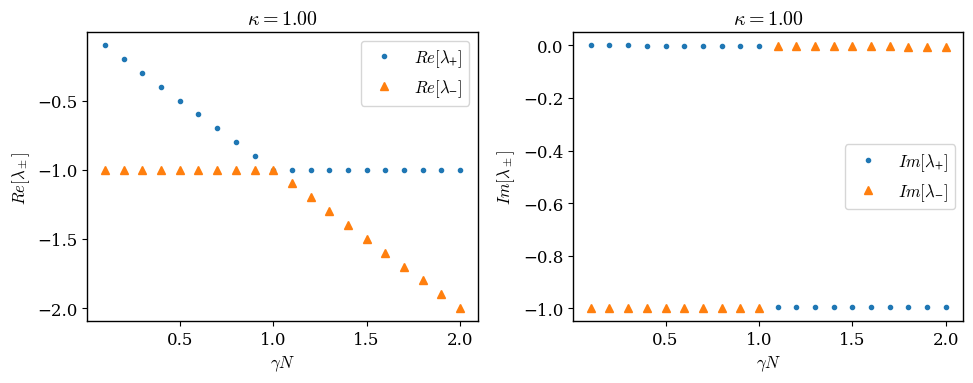

In [46]:
# Visualization 

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

k_idx = 4 # kappa index
ax1 = axes[0]


#ax1.plot(gamma*N, np.real(eigval_comp_0[3,:]),'*')
#ax1.plot(gamma*N, np.real(eigval_comp_1[3,:]),'d')
ax1.plot(gamma*N, np.real(lambda_plus_theory[k_idx,:]),'.', label = r'$Re[\lambda_\plus]$')
ax1.plot(gamma*N, np.real(lambda_minus_theory[k_idx,:]),'^',label = r'$Re[\lambda_\minus]$')

ax1.set_ylabel(r"$Re[\lambda_\pm]$")
ax1.set_xlabel(r"$\gamma N$")
ax1.legend()
ax1.set_title(rf'$\kappa = {kappa[k_idx]:.2f}$')

ax2 = axes[1]

#ax2.plot(gamma*N, np.imag(eigval_comp_0[3,:]),'*')
#ax2.plot(gamma*N, np.imag(eigval_comp_1[3,:]),'d')
ax2.plot(gamma*N, np.imag(lambda_plus_theory[k_idx,:]),'.',label = r'$Im[\lambda_\plus]$')
ax2.plot(gamma*N, np.imag(lambda_minus_theory[k_idx,:]),'^',label = r'$Im[\lambda_\minus]$')


ax2.set_ylabel(r"$Im[\lambda_\pm]$")
ax2.set_xlabel(r"$\gamma N$")

ax2.legend()
ax2.set_title(rf'$\kappa = {kappa[k_idx]:.2f}$')


plt.tight_layout()

plt.savefig(rf'../Figures/Biorthogonal/eigval_N500_kappa{kappa[k_idx]}.pdf',bbox_inches = 'tight', transparent = True)
plt.show()